# Lab9.1 The Annotated Encoder-Decoder with Attention
### Пояснена модель Енкодер-Декодер з Механізмом Уваги (Attention)

Нещодавно Александр Раш опублікував блогпост під назвою [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html), у якому він описує модель Transformer з роботи [Attention is All You Need](https://arxiv.org/abs/1706.03762). Цей допис можна розглядати як **приквел** до того: *ми реалізуємо кодувальник-декодувальник з механізмом уваги* на основі (керованих) рекурентних нейронних мереж, тісно дотримуючись оригінальної роботи про нейронний машинний переклад з увагою — ["Neural Machine Translation by Jointly Learning to Align and Translate"](https://arxiv.org/abs/1409.0473) авторства Бахданау та ін. (2015).

Ідея полягає в тому, що ознайомлення з обома блогпостами допоможе вам краще зрозуміти дві дуже впливові архітектури типу "послідовність у послідовність". Якщо у вас є коментарі або пропозиції, будь ласка, дайте знати: [@BastingsJasmijn](https://twitter.com/BastingsJasmijn).


# Архітектура Моделі

Ми будемо моделювати ймовірність \$p(Y\mid X)\$ цільової послідовності \$Y=(y\_1, \dots, y\_{N})\$ за заданої вхідної (вихідної) послідовності \$X=(x\_1, \dots, x\_M)\$ безпосередньо за допомогою нейронної мережі: **Кодувальника-Декодувальника**.


<img src="https://github.com/bastings/annotated_encoder_decoder/blob/master/images/bahdanau.png?raw=1" width="636">

#### Кодувальник

Кодувальник зчитує вхідне речення (*внизу на схемі*) та створює послідовність прихованих станів \$\mathbf{h}\_1, \dots, \mathbf{h}\_M\$, по одному для кожного слова вхідної послідовності. Ці стани мають відображати значення слова в контексті заданого речення.

Ми використаємо двонаправлену рекурентну нейронну мережу (Bi-RNN) як кодувальник; зокрема, двонаправлену GRU (Bi-GRU).

Перш за все ми **вбудовуємо** слова вхідної послідовності.
Це означає, що для кожного слова ми просто знаходимо його **векторне представлення** (вбудовування слова) у (випадково ініціалізованій) таблиці пошуку.
Векторне представлення для слова \$i\$ у реченні ми позначимо як \$\mathbf{x}\_i\$.
Завдяки вбудовуванню слів модель може використовувати той факт, що певні слова (наприклад, *cat* і *dog*) є семантично подібними і можуть оброблятися схожим чином.

Як же отримати приховані стани \$\mathbf{h}\_1, \dots, \mathbf{h}\_M\$?
Одна GRU (передня) читає речення зліва направо, інша (задня) — справа наліво.
Кожна з них працює за простою рекурсивною формулою:
$\mathbf{h}_j = \text{GRU}( \mathbf{x}_j , \mathbf{h}_{j - 1} )$
Тобто, ми отримуємо наступний стан на основі попереднього стану та поточного векторного представлення слова.

Прихований стан передньої GRU на кроці \$j\$ міститиме інформацію про те, які слова **передують** слову на цій позиції, але не знатиме, що буде далі. Навпаки, задня GRU знатиме лише про ті слова, які **слідують за** словом на позиції \$j\$.
Об’єднуючи ці два стани (**конкатенація**, позначено синім на схемі), ми отримуємо \$\mathbf{h}\_j\$, який представляє слово \$j\$ в контексті всього речення.



#### Декодувальник

Декодувальник (*у верхній частині схеми*) — це GRU з прихованим станом \$\mathbf{s}\_i\$. Він працює за подібною формулою до кодувальника, але приймає **додаткове входження** — вектор контексту \$\mathbf{c}\_i\$ (*показано жовтим кольором*).

$\mathbf{s}_{i} = f( \mathbf{s}_{i - 1}, \mathbf{y}_{i - 1}, \mathbf{c}_i )$

Тут \$\mathbf{y}\_{i - 1}\$ — це попереднє згенероване слово цільової послідовності (*не показано на схемі*).

На кожному кроці механізм **уваги** динамічно визначає ту частину вхідного речення, яка є найбільш релевантною для передбачення поточного слова.
Це досягається шляхом порівняння останнього стану декодувальника з кожним прихованим станом кодувальника.
У результаті утворюється вектор контексту \$\mathbf{c}\_i\$ (*показано жовтим*).
Механізм уваги буде детально пояснено пізніше.

Після обчислення стану декодувальника \$\mathbf{s}\_i\$, нелінійна функція \$g\$ (яка застосовує [softmax](https://en.wikipedia.org/wiki/Softmax_function)) дає нам ймовірність поточного слова \$y\_i\$:

$p(y_i \mid y_{<i}, x_1^M) = g(\mathbf{s}_i, \mathbf{c}_i, \mathbf{y}_{i - 1})$

Оскільки \$g\$ використовує softmax, результат — це вектор розміру словника вихідної мови, сума елементів якого дорівнює 1.0: це розподіл імовірностей по всіх словах.
Під час тестування ми обираємо слово з найбільшою ймовірністю як поточний вихід перекладу.

Для оптимізації використовується функція [втрат крос-ентропії (cross-entropy loss)](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy), щоб максимізувати ймовірність правильного вибору слова на кожному кроці.
Усі параметри моделі (включаючи вбудовування слів) оновлюються для максимізації цієї ймовірності.


# Попередні вимоги

Цей підручник вимагає **PyTorch версії ≥ 0.4.1** і був протестований з **Python 3.6**.

Переконайтеся, що у вас встановлені ці версії, і встановіть наведені нижче пакети, якщо вони ще не встановлені.

In [17]:
!pip install torch numpy matplotlib sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# Ми будемо використовувати CUDA, якщо вона доступна
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: False
cuda:0


# Почнемо кодувати!

## Клас моделі

Наша базова модель `EncoderDecoder` дуже схожа на ту, що використовується у *The Annotated Transformer*.

Одна з відмінностей полягає в тому, що наш кодувальник також повертає свої фінальні стани (`encoder_final` нижче), які використовуються для ініціалізації RNN-декодувальника.
Також ми передаємо довжини послідовностей, оскільки RNN потребують цю інформацію.


In [19]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator

    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)

    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)

    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

Щоб усе залишалося простим, ми також залишаємо клас `Generator` без змін.

Він просто проєктує попередній вихід (\$x\$ у функції `forward`, наведеної нижче) на вихідний шар, щоб отримати вектор, розмір якого відповідає розміру словника цільової мови.


In [20]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder

Наш кодувальник — це двонаправлений GRU.

Оскільки ми хочемо обробляти декілька речень одночасно для підвищення швидкості (це ефективніше на GPU), нам потрібно підтримувати **мікропакети (mini-batches)**.
Речення в одному мікропакеті можуть мати різну довжину, а це означає, що RNN має розгортатися довше для деяких речень, тоді як для інших він може вже завершити обробку:

```
Приклад: мікропакет з 3 вхідних речень різної довжини (7, 5 та 3).
Кінець послідовності позначено цифрою «3», а позиції доповнення (padding) — цифрою «1».

+---------------+
| 4 5 9 8 7 8 3 |
+---------------+
| 5 4 8 7 3 1 1 |
+---------------+
| 5 8 3 1 1 1 1 |
+---------------+
```
Ви можете помітити, що при обчисленні прихованих станів для цього мікропакету для речень №2 та №3 нам потрібно припинити оновлення прихованого стану після того, як ми зустріли символ "3" (кінець послідовності). Ми не хочемо враховувати значення доповнення (1-ці).

На щастя, у PyTorch є зручні допоміжні функції `pack_padded_sequence` і `pad_packed_sequence`.
Вони автоматично обробляють маскування та доповнення, так що після завершення речення відповідні векторні представлення просто заповнюються нулями.

Код нижче зчитує вхідне речення (послідовність вбудованих векторів слів) і генерує приховані стани.
Також він повертає фінальний вектор — узагальнення усього речення, яке отримується конкатенацією першого і останнього прихованих станів (вони обидва «побачили» все речення, але у різних напрямках). Цей фінальний вектор ми використаємо для ініціалізації декодувальника.


In [21]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, bidirectional=True, dropout=dropout)

    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # Нам потрібно вручну об’єднати (конкатенувати) фінальні стани обох напрямків.
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

### Декодувальник

Декодувальник — це умовний GRU.
На відміну від кодувальника, який починає з порожнього стану, початковий прихований стан декодувальника отримується шляхом проєкції фінального вектора кодувальника.

#### Навчання

У методі `forward` є цикл, який обчислює приховані стани декодувальника по одному кроку за раз.
Варто зауважити, що під час навчання ми точно знаємо, якими мають бути цільові слова! (Вони знаходяться в `trg_embed`.) Це означає, що ми навіть не перевіряємо тут, що передбачає модель! Ми просто подаємо правильне попереднє вбудоване слово цільової послідовності на GRU на кожному кроці. Це називається **teacher forcing** (навчання з підказкою).

Метод `forward` повертає всі приховані стани декодувальника та вектори перед виходом (pre-output). Ці дані потім використовуються для обчислення функції втрат, після чого оновлюються параметри моделі.

#### Прогнозування

Під час прогнозування метод `forward` виконується тільки для одного кроку.
Після передбачення слова з поверненого вектора pre-output, ми можемо викликати `forward` знову, передаючи в нього вбудування раніше передбаченого слова та останній прихований стан.


In [22]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""

    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout

        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)

        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)

    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output

    def forward(self, trg_embed, encoder_hidden, encoder_final,
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""

        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)

        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)

        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []

        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))


### Attention                                                                                                                                                                               

На кожному кроці декодувальник має доступ до *всіх* векторних представлень слів джерела — \$\mathbf{h}\_1, \dots, \mathbf{h}\_M\$.
Механізм уваги дозволяє моделі зосередитися на найбільш релевантній частині вхідного речення на даний момент.
Стан декодувальника описується прихованим станом GRU — \$\mathbf{s}\_i\$.
Щоб визначити, які векторні представлення слів джерела \$\mathbf{h}\_j\$ є найбільш релевантними, потрібно задати функцію, що приймає ці два аргументи на вхід.

Тут ми використовуємо багатошаровий перцептрон (MLP) для адитивної уваги, як це зроблено у роботі Бахданау та співавт. (Bahdanau et al.):

<img src="https://github.com/bastings/annotated_encoder_decoder/blob/master/images/attention.png?raw=1" width="280">


Ми застосовуємо багатошаровий перцептрон (MLP) з активацією tanh як до поточного стану декодувальника \$\mathbf{s}\_i\$ (це *запит*), так і до кожного стану кодувальника \$\mathbf{h}*j\$ (це *ключ*), а потім проєктуємо результат у одне скалярне значення — *енергію уваги* \$e*{ij}\$.

Після обчислення всіх енергій вони нормалізуються за допомогою softmax, щоб їх сума дорівнювала одиниці:

$$ \alpha_{ij} = \text{softmax}(\mathbf{e}_i)[j] $$

$$\sum_j \alpha_{ij} = 1.0$$

Вектор контексту на кроці часу \$i\$ — це зважена сума прихованих станів кодувальника (тобто *значень*):
$$\mathbf{c}_i = \sum_j \alpha_{ij} \mathbf{h}_j$$

In [23]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""

    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()

        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)

        # to store attention scores
        self.alphas = None

    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)

        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)

        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))

        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas

        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)

        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

## Вбудовування (Embeddings) та Softmax

Ми використовуємо навчальні вбудовування (learned embeddings), щоб перетворити вхідні та вихідні токени у вектори розмірності `emb_size`.

Для цього ми просто використовуємо стандартні засоби PyTorch — `nn.Embedding`.
 [nn.Embedding](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) class.

## Повна модель

Тут ми визначаємо функцію, яка за гіперпараметрами створює повну модель.

In [24]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

# Навчання

У цьому розділі описується режим навчання наших моделей.

Зробимо невелику паузу, щоб познайомитись із деякими інструментами, необхідними для навчання стандартної моделі кодувальник-декодувальник.
Спочатку визначимо об’єкт `batch`, який зберігатиме вхідні (src) та цільові (target) речення для навчання, а також їх довжини і маски.

## Batches and Masking

In [25]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):

        src, src_lengths = src

        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)

        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()

        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()


## Цикл навчання

Код нижче навчає модель протягом 1 епохи (1 проходу по тренувальних даних).

In [26]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):

        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens

        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))

## Навчальні дані та формування батчів

Для формування батчів ми використовуватимемо бібліотеку torchtext. Про це буде розказано детальніше нижче.

## Оптимізатор

Ми будемо використовувати [оптимізатор Adam](https://arxiv.org/abs/1412.6980) з типовими налаштуваннями (\$\beta\_1=0.9\$, \$\beta\_2=0.999\$, \$\epsilon=10^{-8}\$).

Як швидкість навчання (learning rate) тут оберемо \$0.0003\$, але для інших задач може підійти інше значення. Потрібно буде підбирати це параметр експериментально.

# Перший приклад

Можемо почати з простої задачі копіювання. Маючи випадковий набір вхідних символів із невеликого словника, мета — згенерувати ті ж самі символи у вихідній послідовності.

## Synthetic Data

In [27]:
def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)

## Обчислення функції втрат (Loss)

In [29]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

### Вивід прикладів

Щоб відстежувати прогрес під час навчання, ми будемо перекладати кілька прикладів.

Для простоти використовуємо жадібне декодування (greedy decoding): на кожному кроці, починаючи з першого токена, вибираємо слово з максимальною ймовірністю і не повертаємось до попередніх виборів.

In [30]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())

    output = np.array(output)

    # cut off everything starting from </s>
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]

    return output, np.concatenate(attention_scores, axis=1)


def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [31]:
def print_examples(example_iter, model, n=2, max_len=100,
                   sos_index=1,
                   src_eos_index=None,
                   trg_eos_index=None,
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()

    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None

    for i, batch in enumerate(example_iter):

        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg

        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()

        count += 1
        if count == n:
            break

## Навчання задачі копіювання

In [32]:
def train_copy_task():
    """Train the simple copy task."""
    num_words = 11
    criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    model = make_model(num_words, num_words, emb_size=32, hidden_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    eval_data = list(data_gen(num_words=num_words, batch_size=1, num_batches=100))

    dev_perplexities = []

    if USE_CUDA:
        model.cuda()

    for epoch in range(10):

        print("Epoch %d" % epoch)

        # train
        model.train()
        data = data_gen(num_words=num_words, batch_size=32, num_batches=100)
        run_epoch(data, model,
                  SimpleLossCompute(model.generator, criterion, optim))

        # evaluate
        model.eval()
        with torch.no_grad():
            perplexity = run_epoch(eval_data, model,
                                   SimpleLossCompute(model.generator, criterion, None))
            print("Evaluation perplexity: %f" % perplexity)
            dev_perplexities.append(perplexity)
            print_examples(eval_data, model, n=2, max_len=9)

    return dev_perplexities

/Users/boykosvitlana/dl_venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 0
Epoch Step: 50 Loss: 19.712404 Tokens per Sec: 9042.240143
Epoch Step: 100 Loss: 17.804193 Tokens per Sec: 10960.161853
Evaluation perplexity: 7.159559

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  5 8 7 5 8 7 5 5 8

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 8 8 8 8 8 8 8

Epoch 1
Epoch Step: 50 Loss: 15.360044 Tokens per Sec: 12528.844814
Epoch Step: 100 Loss: 11.845239 Tokens per Sec: 12009.364755
Evaluation perplexity: 3.776112

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 7 5 3 5 7 8 5

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 8 2 5 8 3 2

Epoch 2
Epoch Step: 50 Loss: 10.008592 Tokens per Sec: 10933.551577
Epoch Step: 100 Loss: 9.149925 Tokens per Sec: 14242.390878
Evaluation perplexity: 2.607750

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 3 5 7 8 10

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 

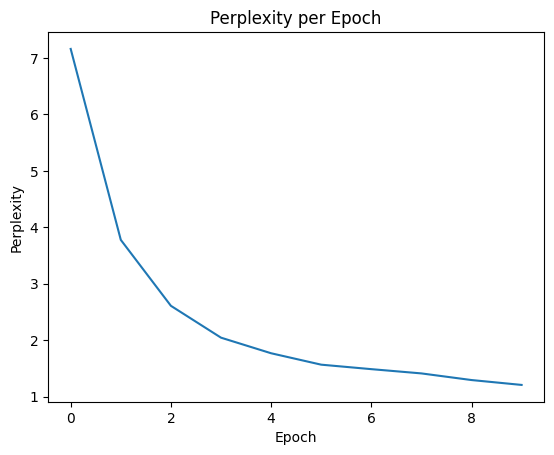

In [33]:
# train the copy task
dev_perplexities = train_copy_task()

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

plot_perplexity(dev_perplexities)

Ви можете побачити, що модель змогла правильно «перекласти» два приклади наприкінці.

Крім того, перплексія на валідаційних даних гарно знизилася до близько 1.

# Приклад з реального світу

Тепер розглянемо реальний приклад на задачі перекладу з німецької на англійську з набору даних IWSLT.
Ця задача набагато менша за звичайні, але добре ілюструє роботу всієї системи.

Наступна комірка встановлює бібліотеки torchtext і spaCy. Це може зайняти деякий час.


In [35]:
!pip install git+git://github.com/pytorch/text spacy
!python -m spacy download en
!python -m spacy download de

  Cloning git://github.com/pytorch/text to /private/var/folders/d_/m95y8vmd14s17wr96v8ppn_c0000gn/T/pip-req-build-jwlyr3r1
  Running command git clone --filter=blob:none --quiet git://github.com/pytorch/text /private/var/folders/d_/m95y8vmd14s17wr96v8ppn_c0000gn/T/pip-req-build-jwlyr3r1
  fatal: unable to connect to github.com:
  github.com[0: 140.82.121.3]: errno=Operation timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/pytorch/text /private/var/folders/d_/m95y8vmd14s17wr96v8ppn_c0000gn/T/pip-req-build-jwlyr3r1 did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet git://github.com/pytorch/text /private/var/folders/d_/m95y8vmd14s17wr96v8ppn_c0000gn/T/pip-req-build-jwlyr3r1 did not run successfully.
│ exit code: 128
╰─> See above for output.

n

## Завантаження даних

Ми завантажимо датасет за допомогою torchtext і spacy для токенізації.

Ця комірка може виконуватися довго при першому запуску, оскільки вона завантажує та токенізує дані IWSLT.

Для прискорення ми включаємо лише короткі речення, а слово додаємо до словника тільки якщо воно зустрічається щонайменше 5 разів. У цьому випадку ми також переводимо дані у нижній регістр.

Якщо у вас виникнуть **проблеми** з torchtext у наведеній комірці (наприклад, помилка `ascii`), спробуйте перед запуском `jupyter notebook` виконати команду:

If you have **issues** with torch text in the cell below (e.g. an `ascii` error), try running `export LC_ALL="en_US.UTF-8"` before you start `jupyter notebook`.



In [51]:
# For data loading.


from torchtext import data, datasets
import nltk

if True:


    def tokenize_de(text):
        return [tok.text for tok in nltk.tokenize(text)]

    def tokenize_en(text):
        return [tok.text for tok in nltk.tokenize(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True

    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_de,
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en,
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG),
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)

    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


OSError: dlopen(/Users/boykosvitlana/dl_venv/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so, 0x0006): Symbol not found: __ZN3c105ErrorC1ENSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEES7_PKv
  Referenced from: /Users/boykosvitlana/dl_venv/lib/python3.11/site-packages/torchtext/lib/libtorchtext.so
  Expected in: /Users/boykosvitlana/dl_venv/lib/python3.11/site-packages/torch/lib/libc10.dylib

### Давайте подивимось на дані

Ніколи не зашкодить переглянути свої дані та деякі статистики.

In [44]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")


print_data_info(train_data, valid_data, test_data, SRC, TRG)

NameError: name 'train_data' is not defined

## Ітератори

Пакетна обробка (batching) має величезне значення для швидкості. Тут ми використаємо `BucketIterator` з torchtext, щоб отримувати пакети речень, які мають (майже) однакову довжину.

#### Примітка щодо сортування пакетів для RNN у PyTorch

Для ефективності PyTorch RNN вимагають, щоб пакети були відсортовані за довжиною, причому найдовше речення в пакеті йде першим. Для тренування ми просто сортуємо кожен пакет.
Для валідації можуть виникнути проблеми, якщо потрібно порівнювати наші переклади з якимось зовнішнім файлом, який не відсортований. Тому для валідації ми просто встановлюємо розмір пакету рівним 1, щоб зберегти оригінальний порядок.


In [ ]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True,
                                 sort_within_batch=True,
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False,
                           device=DEVICE)


def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

## Training the System

Now we train the model.

On a Titan X GPU, this runs at ~18,000 tokens per second with a batch size of 64.

In [ ]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""

    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    dev_perplexities = []

    for epoch in range(num_epochs):

        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter),
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)

        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter),
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter),
                                       model,
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)

    return dev_perplexities


In [ ]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100)

In [ ]:
plot_perplexity(dev_perplexities)

## Передбачення та оцінювання

Після навчання ми можемо використовувати модель для створення перекладів.

Якщо ми перекладемо весь валідаційний набір, то зможемо скористатися [SacreBLEU](https://github.com/mjpost/sacreBLEU), щоб отримати [BLEU-оцінку](https://uk.wikipedia.org/wiki/BLEU) — найпоширеніший спосіб оцінювання якості машинного перекладу.


### ⚠️ Важлива примітка

Зазвичай SacreBLEU запускають з **командного рядка**, використовуючи згенерований файл з перекладами та оригінальний (можливо, токенізований) файл з еталонними перекладами. Це дозволяє отримати зручний рядок версії, який показує, як саме було обчислено BLEU: чи було використано нижній регістр, токенізацію (і яку саме), а також який тип згладжування використовувався.
Якщо ви хочете дізнатися більше про правильне обчислення BLEU, радимо прочитати [цю статтю](https://arxiv.org/abs/1804.08771).

Але оскільки наразі наші попередньо оброблені дані зберігаються тільки в оперативній памʼяті (і не збережені у файли), для демонстрації BLEU ми обчислимо його прямо у ноутбуці. Спершу протестуємо базову функцію BLEU.


In [45]:
import sacrebleu

In [46]:
# this should result in a perfect BLEU of 100%
hypotheses = ["this is a test"]
references = ["this is a test"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

100.00000000000004


In [47]:
# here the BLEU score will be lower, because some n-grams won't match
hypotheses = ["this is a test"]
references = ["this is a fest"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

22.360679774997894


Оскільки ми виконали фільтрацію для пришвидшення, наш валідаційний набір містить 690 речень.
Референси (еталонні переклади) — це токенізовані версії, але вони **не повинні містити токенів UNK** (тобто слів поза словником), які могла б згенерувати наша мережа.

Тому ми просто беремо референси безпосередньо з об'єкта `valid_data`.

In [48]:
len(valid_data)

NameError: name 'valid_data' is not defined

In [49]:
references = [" ".join(example.trg) for example in valid_data]
print(len(references))
print(references[0])

NameError: name 'valid_data' is not defined

In [50]:
references[-2]

IndexError: list index out of range

**Now we translate the validation set!**

This might take a little bit of time.

Note that `greedy_decode` will cut-off the sentence when it encounters the end-of-sequence symbol, if we provide it the index of that symbol.

In [ ]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model, batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

In [ ]:
# we will still need to convert the indices to actual words!
hypotheses[0]

In [ ]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses[0]

In [ ]:
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

In [ ]:
# now we can compute the BLEU score!
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

## Attention Visualization

We can also visualize the attention scores of the decoder.

In [ ]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [ ]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 5
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)

Вітаємо! Ви завершили цей ноутбук.

### Що ми **не** розглянули?

* **Субслова / Byte Pair Encoding (BPE)** [\[стаття\]](https://arxiv.org/abs/1508.07909) [\[репозиторій\]](https://github.com/rsennrich/subword-nmt): дозволяють ефективно працювати з невідомими словами, розбиваючи їх на частини.
* **Мультиплікативну / білінійну механіку уваги** можна реалізувати замість додаткової (additive) уваги, яка використовується тут [\[стаття\]](https://arxiv.org/abs/1508.04025).
* Ми використали **жадібне декодування** (greedy decoding), але **beam search** дає кращі результати, розглядаючи декілька варіантів водночас.
* **Dropout** ми використовували лише один раз у декодері. Можна експериментувати з додатковими шарами dropout: на словникових векторах, виходах енкодера тощо.
* Можна спробувати **кілька шарів енкодера/декодера** замість одного, як у цій реалізації.
* Для практичних експериментів радимо ознайомитися з удосконаленою системою: [Joey NMT](https://github.com/joeynmt/joeynmt) — простий, але потужний фреймворк для нейромашинного перекладу.

Якщо хочеш, можемо спробувати реалізувати щось із цього разом.

If this was useful to your research, please consider citing:

> J Bastings. 2018. The Annotated Encoder-Decoder with Attention. https://bastings.github.io/annotated_encoder_decoder/

Or use the following `Bibtex`:
```
@misc{bastings2018annotated,
  title={The Annotated Encoder-Decoder with Attention},
  author={Bastings, J.},
  journal={https://bastings.github.io/annotated\_encoder\_decoder/},
  year={2018}
}```